In [1]:
import torch
from PIL import Image
import numpy as np

In [2]:
from rrdbnet_arch import RRDBNet
from utils_sr import *

model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=8)
model.load_state_dict(torch.load('models/RealESRGAN_x8.pth'), strict=True)
model = model.eval()

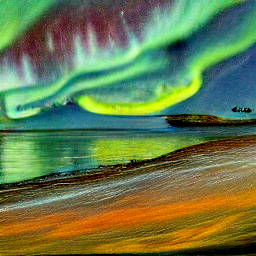

In [3]:
path_to_image = '/home/airplaneless/source/pythonstuff/dalle-trt-inference/renders/aurora_in_antarctica_oil_painting/0_0.png'
lr_image = Image.open(path_to_image).convert('RGB')
lr_image

In [4]:
lr_image = np.array(lr_image)
lr_image = pad_reflect(lr_image, 15)

patches, p_shape = split_image_into_overlapping_patches(lr_image, patch_size=192, 
                                                        padding_size=24)
img = torch.FloatTensor(patches/255).permute((0,3,1,2)).detach()

with torch.no_grad():
    res = model(img[0:4])
    for i in range(4, img.shape[0], 4):
        res = torch.cat((res, model(img[i:i+4])), 0)

sr_image = res.permute((0,2,3,1)).clamp_(0, 1).cpu()
np_sr_image = sr_image.numpy()

padded_size_scaled = tuple(np.multiply(p_shape[0:2], 8)) + (3,)
scaled_image_shape = tuple(np.multiply(lr_image.shape[0:2], 8)) + (3,)
np_sr_image = stich_together(np_sr_image, padded_image_shape=padded_size_scaled,
                        target_shape=scaled_image_shape, padding_size=24 * 8)
sr_img = (np_sr_image*255).astype(np.uint8)
sr_img = unpad_image(sr_img, 15*8)
sr_img = Image.fromarray(sr_img)

In [5]:
sr_image.shape

torch.Size([4, 1920, 1920, 3])

In [6]:
img.shape

torch.Size([4, 3, 240, 240])

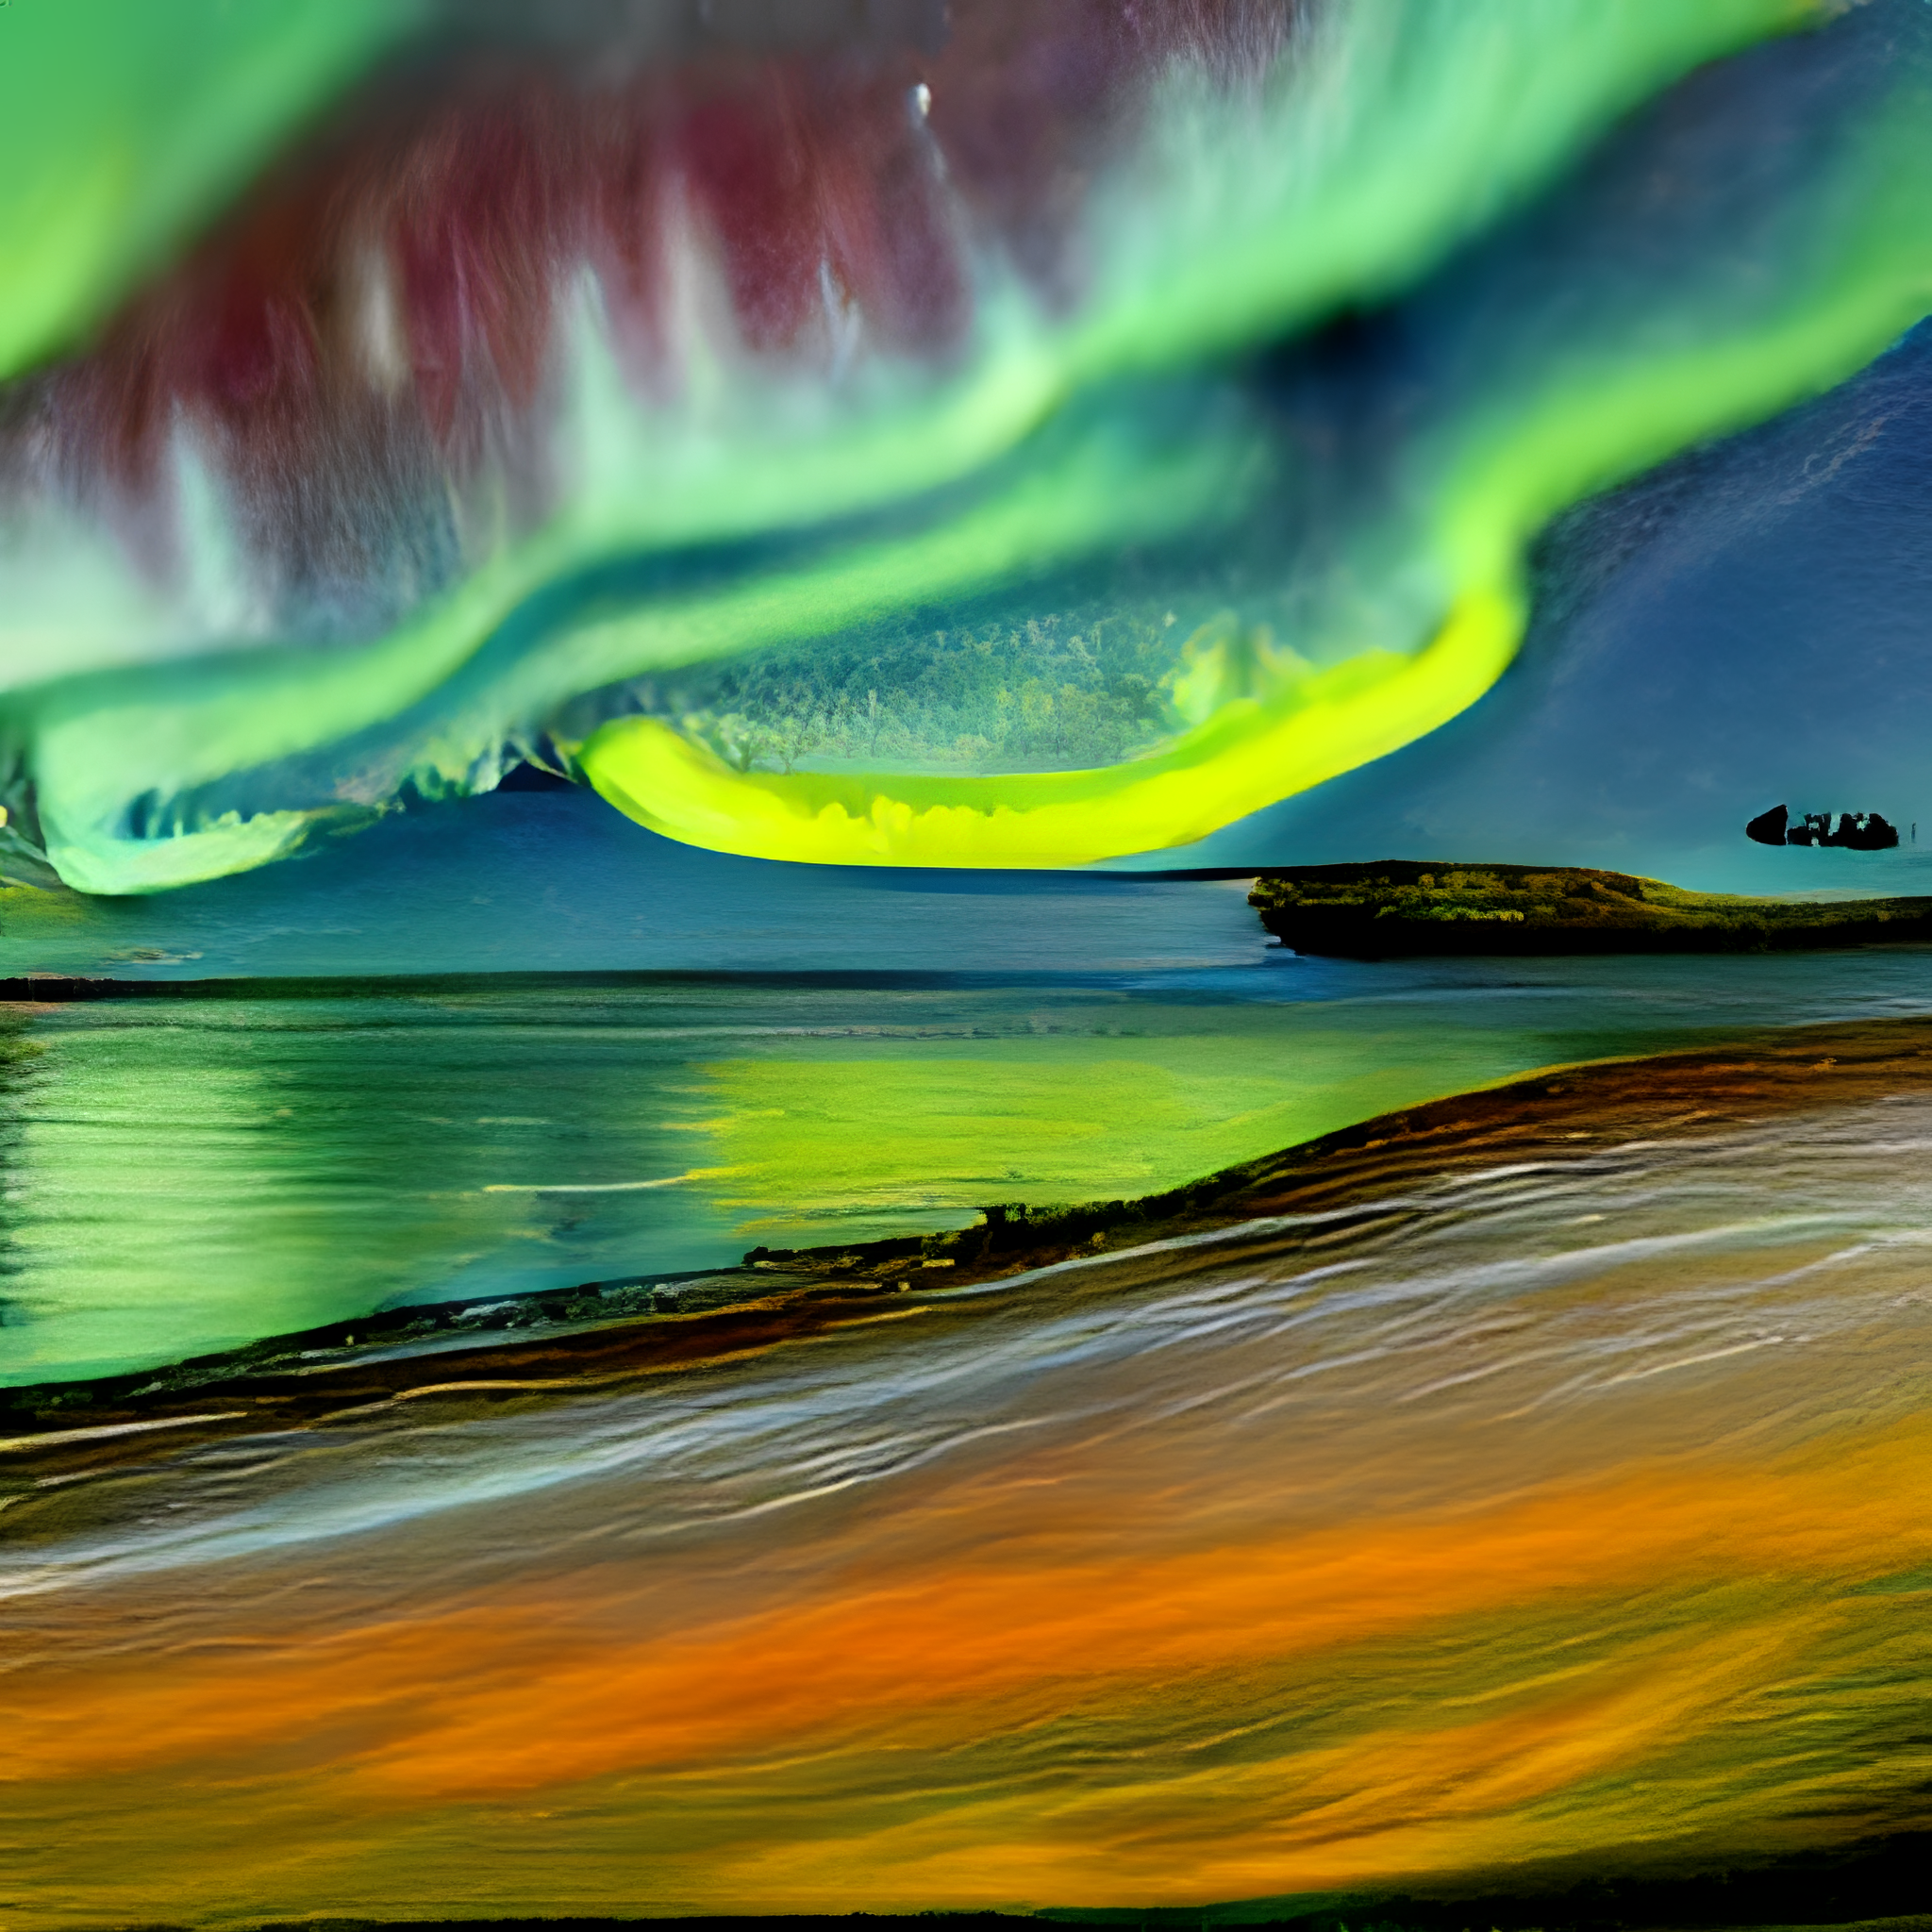

In [7]:
sr_img